### Each level of complexity is plotted separately ###

read
plot


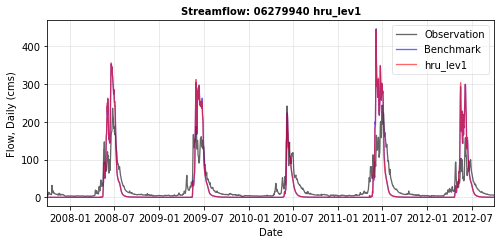

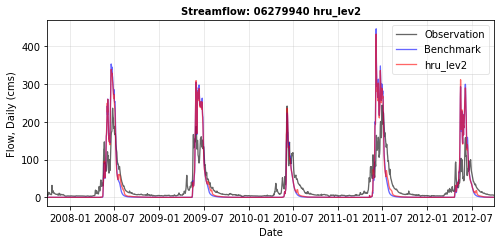

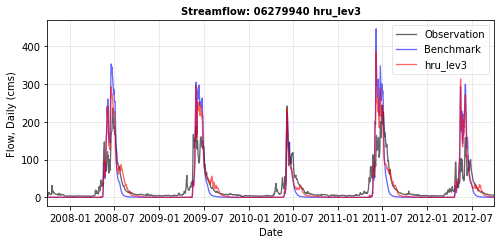

save
Done


In [7]:
# compare route outputs from different levels of complexity
import os,datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from PIL import Image

root_dir='/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/model'
level_num=3
label_basename='hru_lev'
basinName='06279940'
model_dir = os.path.join(root_dir,basinName)

obsFile=os.path.join(root_dir,'obs','obs_flow.'+basinName+'.cfs.csv')
obsVoid=-9999.0

time_format = '%Y-%m-%d'
plot_date_start = '2007-10-01'
plot_date_end = '2012-09-30'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

output_dir=os.path.join(model_dir,'analysis/5_compare_level_sim')
ofile = 'compare_sim_'+basinName+'.png'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# --- read observed flow from CSV file (cfs)
df_obs = pd.read_csv(obsFile, header=0, sep=',', index_col=0, parse_dates=[0],
                     keep_default_na=False, na_values=[obsVoid])
df_obs = df_obs.apply(pd.to_numeric, errors='coerce')   # convert 'str' data column to float
df_obs.rename(columns={df_obs.columns[0]:'Observed'}, inplace=True)
df_obs['Observed'] = df_obs['Observed'].div(35.315)    # convert to m^3/s

# --- read summa simulated output
print('read')
q_dic = {}
for level_id in range(level_num+1):
    label=label_basename+str(level_id)
    
    q_ncfile = os.path.join(model_dir,'route_output','sflow.'+label+'.h.1970-03-02-00000.nc')
    ds = xr.open_dataset(q_ncfile) 
    time = ds['time'].values[:]
    time = pd.to_datetime(time)
    q =  ds['IRFroutedRunoff'].values[:] #(time, gru)

    df = pd.DataFrame(q, index=time)
    q_dic[label]=df

# --- plot summa simulated output
print('plot')
seg_id = 10
fontsize = 'medium' #'large'
fig_file_summary = []

for level_id in range(1,level_num+1):
    label=label_basename+str(level_id)    
    fig, ax = plt.subplots(1,1,figsize=[7.08, 3.5]) 

    # plot obs flow
    df_obs_cut = df_obs.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_obs_cut.index, df_obs_cut['Observed'], color='k', linestyle='-', linewidth=1.3, 
                 markersize=0.0, alpha=0.6, label='Observation')

    # plot level0 sim flow
    label0=label_basename+str(0)
    df = q_dic[label0]
    df_cut = df.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_cut.index, df_cut[seg_id], color='b', linestyle='-', 
                 linewidth=1.3, markersize=0.0, alpha=0.6, label='Benchmark')
    
    # plot another level sim flow
    df = q_dic[label]
    df_cut = df.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_cut.index, df_cut[seg_id], color='r', linestyle='-', 
                 linewidth=1.3, markersize=0.0, alpha=0.6, label=label)

    # others
    ax.set_title('Streamflow: ' + basinName + ' '+label,
                 fontsize=fontsize,weight='semibold')
    ax.set_xlim(df_cut.index[0],df_cut.index[-1])
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_tick_params(labelsize=fontsize)#rotation=30,
    ax.legend(loc='best', fontsize=fontsize, framealpha=0.5) #loc='upper right', 

    ax.set_xlabel('Date', fontsize=fontsize)
    ax.set_ylabel('Flow, Daily (cms)', fontsize=fontsize)
    ax.tick_params(direction='out', labelsize=fontsize)
    ax.grid(True,linewidth=0.5,alpha=0.5)

    fig.tight_layout()
    ofile = 'compare_sim_'+basinName+'_'+label+'.png'
    plt.savefig(os.path.join(output_dir,ofile), dpi=80)
    fig_file_summary.append(os.path.join(output_dir,ofile)) 
    
    plt.show()
    plt.close(fig)
    
# --- merge and save as one figure
print('save')
widths = []
heights = []
for fig_file in fig_file_summary:
    im = Image.open(fig_file)
    widths.append(im.width)
    heights.append(im.height)

col_num = 1
row_num = len(fig_file_summary)

total_width = int(max(widths)*col_num)
total_height = int(max(heights)*row_num)
new_im = Image.new('RGB', (total_width, total_height))

for col in range(col_num):
    for row in range(row_num):
        k = row*col_num+col
        fig_file = fig_file_summary[k]
        im = Image.open(fig_file)   

        x_offset_width = im.size[0]
        x_offset_height = im.size[1]
        new_im.paste(im, (x_offset_width*col,x_offset_height*row))

ofile = 'compare_sim_'+basinName+'.png'
new_im.save(os.path.join(output_dir,ofile))

print('Done')

In [37]:
os.path.join(output_dir,ofile)

'/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/model/06279940/analysis/5_compare_level_sim/compare_sim_06279940_hru_lev3.png'